In [1]:
from pathlib import Path

In [2]:
import polars as pl

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

In [5]:
import geopandas as gpd

In [6]:
datasets = Path("__file__").absolute().parent.parent / "datasets/trusted"

In [7]:
list(datasets.iterdir())

[PosixPath('/home/marconso/Github/sinan_amazonas/Modelling_health_outcome_indigenous_pop/datasets/trusted/tuberculose2005_2014.parquet'),
 PosixPath('/home/marconso/Github/sinan_amazonas/Modelling_health_outcome_indigenous_pop/datasets/trusted/tuberculose2015_2024.parquet'),
 PosixPath('/home/marconso/Github/sinan_amazonas/Modelling_health_outcome_indigenous_pop/datasets/trusted/dados_final_consolidado.xlsx'),
 PosixPath('/home/marconso/Github/sinan_amazonas/Modelling_health_outcome_indigenous_pop/datasets/trusted/dsei.xlsx'),
 PosixPath('/home/marconso/Github/sinan_amazonas/Modelling_health_outcome_indigenous_pop/datasets/trusted/plot.png')]

In [8]:
dtb = pl.read_csv("/opt/storage/raw/aesop/visualization/DTB.csv").join(
    pl.DataFrame(
        {
            "data": pl.date_range(
                start=pl.date(2005, 1, 1), end=pl.date(2025, 1, 1), interval="1d", eager=True
            )
        }
    ), how="cross"
).with_columns(pl.col("data").map_elements(lambda x: str(x)[:-3], return_dtype=pl.String).alias("year_month"))

In [9]:
dsei = pl.read_excel("/home/marconso/Github/sinan_amazonas/Modelling_health_outcome_indigenous_pop/datasets/trusted/dsei.xlsx").rename({"idm_ioibge": "ibge"}).with_columns(pl.col("ibge").cast(pl.Int32))

In [10]:
dsei["ibge"].unique().len()

5570

In [11]:
df_clima = pl.read_excel(datasets / "dados_final_consolidado.xlsx")

In [12]:
df_clima["ibge"].unique().len(), df_clima["data_inicio"].min(), df_clima["data_fim"].max(), df_clima["descricao_tipologia"].unique().len()

(5106, datetime.date(1970, 8, 26), datetime.date(2022, 12, 30), 16)

In [13]:
sorted(df_clima["descricao_tipologia"].unique().to_list())

['Alagamentos',
 'Chuvas Intensas',
 'Doenças infecciosas',
 'Enxurradas',
 'Erosão',
 'Estiagem e Seca',
 'Granizo',
 'Incêndio Florestal',
 'Inundações',
 'Movimento de Massa',
 'Onda de Calor e Baixa Umidade',
 'Onda de Frio',
 'Outros',
 'Rompimento/Colapso de barragens',
 'Tornado',
 'Vendavais e Ciclones']

In [14]:
df04_14 = df_clima.filter((pl.col("data_inicio").dt.year() >= 2004) & (pl.col("data_fim").dt.year() <= 2022)) # 2004 como lag de 1 ano (talvez aparecam em 2005) para novos relatos de tuberculose

In [15]:
sorted(df04_14["descricao_tipologia"].unique().to_list())

['Alagamentos',
 'Chuvas Intensas',
 'Doenças infecciosas',
 'Enxurradas',
 'Erosão',
 'Estiagem e Seca',
 'Granizo',
 'Incêndio Florestal',
 'Inundações',
 'Movimento de Massa',
 'Onda de Calor e Baixa Umidade',
 'Onda de Frio',
 'Outros',
 'Rompimento/Colapso de barragens',
 'Tornado',
 'Vendavais e Ciclones']

In [16]:
df04_14["grupo_de_desastre"].unique().to_list()

['Outros', 'Climatológico', 'Meteorológico', 'Hidrológico']

In [17]:
df04_14.filter(pl.col("grupo_de_desastre").is_in(["Climatológico"]))["descricao_tipologia"].unique().to_list()

['Estiagem e Seca',
 'Incêndio Florestal',
 'Onda de Calor e Baixa Umidade',
 'Onda de Frio']

In [18]:
df04_14_clima = df04_14.filter(pl.col("grupo_de_desastre").is_in(["Climatológico"])).filter(pl.col("data_fim") > pl.col("data_inicio"))["ibge", "data_inicio", "data_fim", "descricao_tipologia", "grupo_de_desastre", "enfermos"]

In [19]:
df04_14_clima

ibge,data_inicio,data_fim,descricao_tipologia,grupo_de_desastre,enfermos
i64,date,date,str,str,i64
1400704,2009-12-30,2010-01-04,"""Estiagem e Seca""","""Climatológico""",295
1400704,2009-12-30,2010-01-04,"""Estiagem e Seca""","""Climatológico""",295
1505536,2018-08-30,2018-10-13,"""Incêndio Florestal""","""Climatológico""",0
1505536,2018-08-30,2018-10-13,"""Incêndio Florestal""","""Climatológico""",0
1505536,2018-08-30,2018-10-13,"""Incêndio Florestal""","""Climatológico""",0
…,…,…,…,…,…
5213806,2022-07-02,2022-11-11,"""Incêndio Florestal""","""Climatológico""",0
5213806,2022-07-02,2022-11-11,"""Incêndio Florestal""","""Climatológico""",0
5213806,2022-07-02,2022-11-11,"""Incêndio Florestal""","""Climatológico""",0


In [20]:
pv_clima = (
    df04_14_clima.with_columns(
        pl.col("data_inicio").map_elements(lambda x: str(x)[:-3], return_dtype=pl.String).alias("year_month_start"),
        pl.col("data_fim").map_elements(lambda x: str(x)[:-3], return_dtype=pl.String).alias("year_month_end"),
        pl.col("data_inicio").dt.year().alias("year")
    )
    .pivot(index=["year"] , on="descricao_tipologia", values="enfermos", aggregate_function="sum")
    .fill_null(0)
)

/tmp/ipykernel_31235/555104846.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(range(2004, 2023)))


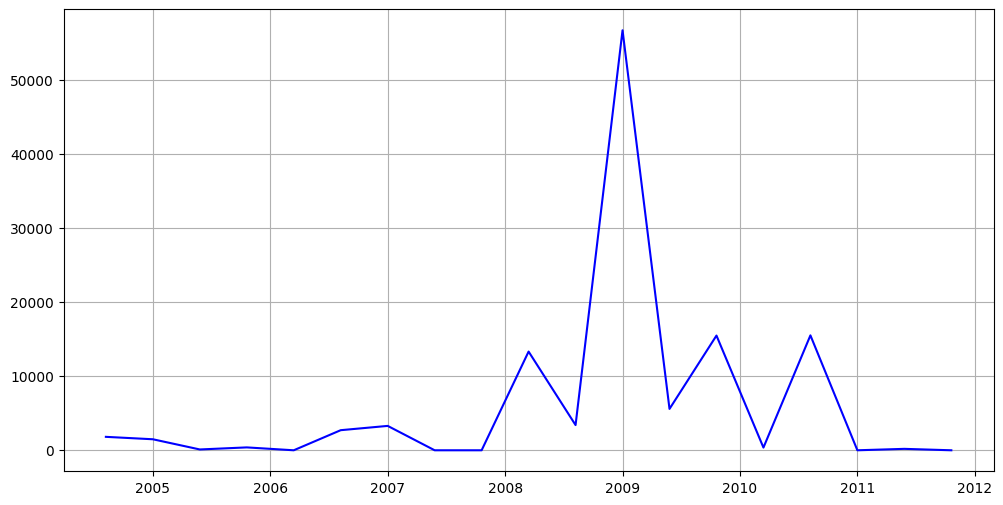

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot("year", "Estiagem e Seca", data=pv_clima.sort("year"), color="blue")
ax.set_xticklabels(list(range(2004, 2023)))
ax.grid(True)
plt.show()

In [22]:
dates = sorted(pv_clima["year"].to_list())
y = pv_clima["Estiagem e Seca"].to_numpy()    

In [23]:
x_num = date2num(dates)
m, b = np.polyfit(x_num, y, 1)
trend_lin = m * x_num + b

In [24]:
window = 3
trend_ma = np.convolve(y, np.ones(window)/window, mode='same')

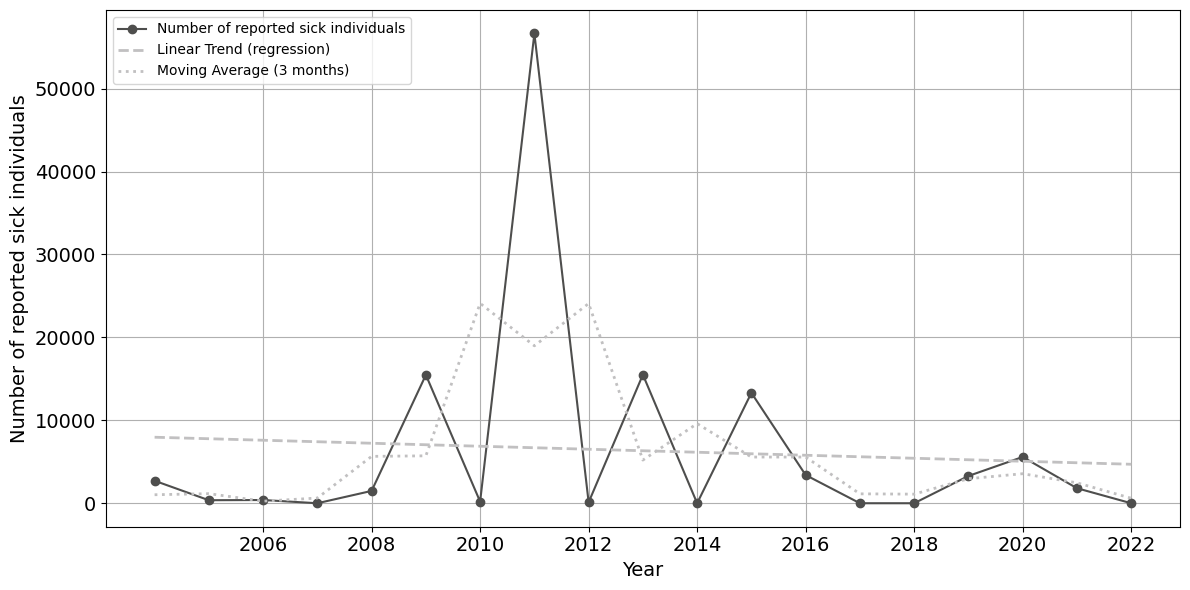

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_facecolor('#ffffff')
ax.plot(dates, y, label="Number of reported sick individuals", color="#4e4e4d", marker="o", linewidth=1.5, linestyle="-")
ax.plot(dates, trend_lin, label="Linear Trend (regression)", color="#c1c0c1", linewidth=2, linestyle="--")
ax.plot(dates, trend_ma, label=f"Moving Average ({window} months)", color="#c1c0c1", linewidth=2, linestyle=":")
ax.legend(
    loc="upper left",
    frameon=True
)
ax.tick_params(labelsize=14)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of reported sick individuals", fontsize=14)
plt.xticks(list(range(2006, 2023, 2)))
plt.grid(True)
plt.tight_layout()
plt.savefig(datasets / "plot.png", dpi=300)
plt.show()